# Route Optimizing Algorithm

## Class and Methods

### Import library

In [ ]:
# Import Library
import copy
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import random
import xlwt

from collections import Counter
from xlwt import Workbook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/Eksternal CL/Consultation/DSE/01 - Optimizing Welding Time/Codes/WDO - 4 Robots - Mini Cases'

### Execution Class
General command to executes program

In [ ]:
# Case optimization
class Execute:

    def __init__(self, nStation, nRobot, coorRobot, vRobot):
        self.nStation = nStation
        self.nRobot = nRobot
        self.coorRobot = coorRobot
        self.typeRobot = np.array(['X', 'C', 'X', 'X'])

        # Read data
        self.readData()

        # Initialize
        self.initialize()

        # properties
        #self.vRobot = 110           # [mm/s]
        self.vRobot = vRobot
        self.tWeld = 1              # [1 s/ components]
        self.tMH = 5                # [s]
        self.tSetup = 5             # [s]
        self.numbJointComp = 3      # Number of minimal components to join
        self.numbFinishIter = 10    # Number of data to finish iteration

        # component
        self.refComponent = np.array([[3, 1],
                                      [3, 2],
                                      [3, 4], #3
                                      [3, 5],
                                      [3, 6], #5
                                      [6, 9], #6
                                      [2, 1],
                                      [2, 7],
                                      [2, 8],
                                      [1, 7]])

        # Post processing
        self.robotDistanceHist = []
        self.robotTimeHist = []
        self.cycleTimeHist = []
        self.liniTimeHist = []
        self.balanceCTHist = []
        self.iterHist = []
        self.robotHist = []
        self.balanceHist = []

    def readData(self):
        fRefCoord = path + '/datas/reference_coordinates.csv'
        rawRefCoord = pd.read_csv(fRefCoord, index_col=0)  # Reference coordinates

        # Edit raw files
        # Reference coordinates
        n, char = rawRefCoord.shape
        self.refCoord = np.zeros((n, char))
        for i in range(char):
            self.refCoord[:, i] = rawRefCoord[rawRefCoord.columns.values[i]]

    def initialize(self):
        # Initialize route in each robot
        self.robotPoints = np.array([[23, 24, 25, 26],
                                     [1, 2, 3, 4, 5, 6, 20],
                                     [94, 93, 52, 53, 22],
                                     [21, 27, 28, 29, 54, 55, 91, 92, 95]])

    def optimize(self, generations, popSize, eliteSize, mutationRate, crossoverRate):
        # Initialization
        self.generations = generations
        self.popSize = popSize
        self.eliteSize = eliteSize
        self.mutationRate = mutationRate
        self.crossoverRate = crossoverRate
        self.robotResult = [0, 0, 0, 0]
        self.robotToOptimize = [1, 1, 1, 1]
        self.performIteration = True


        # Algorithm
        # 0. Calculate initial results
        print(f'>_ Initial Conditions:')
        self.initialResults()

        # 1. Constraint check
        checkType = self.checkTypeGun(self.robotPoints)             # Robot type check
        checkPrecedent = self.checkPrecedent(self.robotPoints)      # Precedent check
        checkComponent = self.checkComponent(self.robotPoints)      # Component check

        if (checkType and checkPrecedent and checkComponent == False):
            print(f'Constraints check is failed. Please change the initial robots route')
        else:
            print(f'> Constraints check, (True => Pass)')
            print(f'1. Check gun-type            : {checkType}')
            print(f'2. Check precedent           : {checkPrecedent}')
            print(f'3. Check component           : {checkComponent}')

            # 2. Optimization
            print(f'')
            print(f'>_ START OPTIMIZING')

            iter = 0
            while (self.performIteration == True):
                # Perform interference algorithm
                print(f'>_ Iteration-{iter+1}')


                # Calculate distance and time
                print(f'> Performing MOGA')
                robotDistance, robotTime, cycleTime, liniTime = self.innerOptimization()

                # Add History
                self.iterHist.append(iter+1)
                self.robotDistanceHist.append(robotDistance)
                self.robotTimeHist.append(robotTime)
                self.cycleTimeHist.append(cycleTime)
                self.liniTimeHist.append(round(liniTime, 3))

                # Check Cycle time balance
                needBalance, balanceValue = self.balanceCTCheck(robotTime)
                self.balanceHist.append(balanceValue)

                print(f'')
                if (needBalance == True):
                    print(f'> Perform Point Balancing')
                    self.donorPoints(robotTime)
                else:
                    print(f'>_ Optimizing is Done')
                    break

                print(f'')
                print(f'> Route for next iteration')
                print(f'Robot Route,')
                for i in range(sum(self.nRobot)):
                    print(f'   Robot-{i+1}                : {self.robotPoints[i]}')
                print(f'')

                iter = iter + 1

            self.postProcessing()
            #self.plotLiniTime()
            #self.plotBalanceTime()
       
    def initialResults(self):
        # Find distance
        exec = distanceCalculation(self.coorRobot)
        robotDistance = []
        tWelding = []
        robotTime = []
        cycleTime = [0, 0, 0]

        # Find Distance Robot
        for i in range(sum(self.nRobot)):
            pointPopulation = np.array([self.robotPoints[i]])
            robotIndex = i
            exec.calculate(pointPopulation, robotIndex)
            robotDistance.append(exec.distance[0])

        # Find Welding Time
        for i in range(sum(self.nRobot)):
            l = robotDistance[i]
            tWelding.append((l/self.vRobot) + (len(self.robotPoints[i])*self.tWeld))

        # Find Setup Time
        setupComponent = self.numberOfComponent(self.robotPoints)

        # Total robot time
        for i in range(sum(self.nRobot)):
            robotTime.append(tWelding[i])

        robotTime[0] = robotTime[0] + (self.tSetup*setupComponent[0]) + self.tMH
        robotTime[1] = robotTime[1] + (self.tSetup*setupComponent[1]) + self.tMH
        robotTime[2] = robotTime[2] + (self.tSetup*setupComponent[1]) + self.tMH
        robotTime[3] = robotTime[3] + (self.tSetup*setupComponent[2]) + self.tMH

        # Cycle time
        cycleTime[0] = robotTime[0]
        cycleTime[1] = max([robotTime[1], robotTime[2]])
        cycleTime[2] = robotTime[3]

        balanceCT = (sum(robotTime) * 100 / (sum(self.nRobot) * max(cycleTime)))

        liniTime = max(cycleTime)

        print(f'> Initial Route')
        print(f'Robot Route: ')
        for i in range(sum(self.nRobot)):
            print(f'   Robot-{i+1}                : {self.robotPoints[i]}')
        print(f'Robot Distance, [mm]      : {np.round(robotDistance, 3)}')
        print(f'Robot Time,     [s]       : {np.round(robotTime, 3)}')
        print(f'Cycle Time,     [s]       : {np.round(cycleTime, 3)}')
        print(f'Lini Time,      [s]       : {np.round(liniTime, 3)}')
        print(f'Balance Cycle Times       : {round(balanceCT, 3)} %')

        return (robotDistance, robotTime)

    def checkTypeGun(self, robotPoint):
        # Check type gun
        # SC 1 -> Gun X
        # SC 2 -> Gun C
        # SC 3 -> Gun X or C

        # Initialization
        results = False
        arrayRes = []

        # Start checking
        for i in range(len(robotPoint)):
            robotType = self.typeRobot[i]

            for point in robotPoint[i]:
                sc = self.refCoord[point-1, 2]

                if (robotType == 'X'):
                    if ((sc == 1) or (sc == 3)):
                        arrayRes.append(True)
                    elif (sc == 2):
                        arrayRes.append(False)
                elif (robotType == 'C'):
                    if ((sc == 2) or (sc == 3)):
                        arrayRes.append(True)
                    elif (sc == 1):
                        arrayRes.append(False)

        if (sum(arrayRes) == 25):
            return (True)
        else:
            return (False)

    def checkPrecedent(self, robotPoint):
        #print(f'---')
        #print(f'Start checking precedent')
        #print(f'---')
        # pcr = 1 -> 1, 11, 21
        # pcr = 2 -> 2, 19, 20

        # Initialization
        dataRegion = dict(Counter(self.refCoord[:,0]))

        # Calculate
        # Station-1
        arrayStat1 = []
        stat1 = False

        # Robot-1
        dfRobot1 = []
        for point in robotPoint[0]:
            level = self.refCoord[point-1, 4]
            if (level == 2):
                arrayStat1.append(False)
            else:
                arrayStat1.append(True)
            dfRobot1.append(self.refCoord[point-1, :])
        dfRobot1 = np.array(dfRobot1)
        dataRegionRobot1 = dict(Counter(dfRobot1[:,0]))

        if (sum(arrayStat1) == (len(robotPoint[0]))):
            stat1 = True

        # Calculate the precedent
        # What is done in station 1
        for val in dataRegionRobot1:
            dataRegion[val] = dataRegion[val] - dataRegionRobot1[val]

        # What will be done in station 2
        arrayStat2 = []
        stat2 = False

        for point in robotPoint[1]:
            prc = self.refCoord[point-1, 5]
            if (prc == 1):
                if ((dataRegion[1] == 0) and (dataRegion[11] == 0) and
                        (dataRegion[21] == 0)):
                    arrayStat2.append(True)
                else:
                    arrayStat2.append(False)
            elif (prc == 2):
                if ((dataRegion[2] == 0) and (dataRegion[19] == 0) and
                        (dataRegion[20] == 0)):
                    arrayStat2.append(True)
                else:
                    arrayStat2.append(False)
            else:
                arrayStat2.append(True)
        
        for point in robotPoint[2]:
            prc = self.refCoord[point-1, 5]
            if (prc == 1):
                if ((dataRegion[1] == 0) and (dataRegion[11] == 0) and
                        (dataRegion[21] == 0)):
                    arrayStat2.append(True)
                else:
                    arrayStat2.append(False)
            elif (prc == 2):
                if ((dataRegion[2] == 0) and (dataRegion[19] == 0) and
                        (dataRegion[20] == 0)):
                    arrayStat2.append(True)
                else:
                    arrayStat2.append(False)
            else:
                arrayStat2.append(True)

        if (sum(arrayStat2) == (len(robotPoint[1]) + len(robotPoint[2]))):
            stat2 = True

        #print(f'Robot 1 : {robotPoint[0]}')
        #print(f'dataRegion1 : {dataRegionRobot1}')
        #print(f'Robot 2 : {robotPoint[1]}')
        #print(f'dataRegion2 : {dataRegionRobot2}')
        #print(f'Status  : {arrayStat2}')
        #print(f'---')

        # What is done in station 2
        # Robot-2
        dfRobot2 = []
        for point in robotPoint[1]:
            dfRobot2.append(self.refCoord[point-1, :])
        dfRobot2 = np.array(dfRobot2)
        dataRegionRobot2 = dict(Counter(dfRobot2[:, 0]))

        # Robot-3
        dfRobot3 = []
        for point in robotPoint[2]:
            dfRobot3.append(self.refCoord[point-1, :])
        dfRobot3 = np.array(dfRobot3)
        dataRegionRobot3 = dict(Counter(dfRobot3[:, 0]))

        for val in dataRegionRobot2:
            dataRegion[val] = dataRegion[val] - dataRegionRobot2[val]
        for val in dataRegionRobot3:
            dataRegion[val] = dataRegion[val] - dataRegionRobot3[val]

        # What will be done in station 3
        arrayStat3 = []
        stat3 = False

        for point in robotPoint[3]:
            prc = self.refCoord[point-1, 5]

            if (prc == 1):
                if ((dataRegion[1] == 0) and (dataRegion[11] == 0) and
                        (dataRegion[21] == 0)):
                    arrayStat3.append(True)
                else:
                    arrayStat3.append(False)
            elif (prc == 2):
                if ((dataRegion[2] == 0) and (dataRegion[19] == 0) and
                        (dataRegion[20] == 0)):
                    arrayStat3.append(True)
                else:
                    arrayStat3.append(False)
            else:
                arrayStat3.append(True)

        if (sum(arrayStat3) == len(robotPoint[3])):
            stat3 = True

        #print(f'Robot 3 : {robotPoint[2]}')
        #print(f'dataRegion3 : {dataRegionRobot3}')
        #print(f'---')
        #print(f'data region: {dataRegion}')
        #print(f'Robot 4 : {robotPoint[3]}')
        #print(f'Robot 5 : {robotPoint[4]}')
        #print(f'Status  : {arrayStat3}')
        #print(f'---')

        if (stat1 and stat2 and stat3):
            return (True)
        else:
            return (False)

    def checkComponent(self, robotPoint):
        # component
        #   1: 3-1
        #   2: 3-2
        #   3: 3-4
        #   4: 3-5
        #   5: 3-6
        #   6: 3-8
        #   7: 2-1
        #   8: 2-7
        #   9: 2-8
        #   10: 1-7

        # Initialization
        threshold = self.numbJointComp
        dataComponent = dict(Counter(self.refCoord[:, 3]))
        for i in dataComponent:
            dataComponent[i] = dataComponent[i] - dataComponent[i]

        # Calculate
        # Station-1
        # Robot-1
        dfRobot = []
        for point in robotPoint[0]:
            dfRobot.append(self.refCoord[point-1, :])
        dfRobot = np.array(dfRobot)
        dataComponentRobot1 = dict(Counter(dfRobot[:, 3]))

        # Calculate the component
        # What is done in station 1
        for i in dataComponentRobot1:
            dataComponent[i] = dataComponent[i] + dataComponentRobot1[i]

        # What will be done in station 2
        arrayStat2 = []
        stat2 = False

        for i in dataComponent:
            if (dataComponent[i]>0):
                if (dataComponent[i]>=threshold):
                    arrayStat2.append(True)
                else:
                    arrayStat2.append(False)

        if (sum(arrayStat2) == len(arrayStat2)):
            stat2 = True

        # What is done in station 2
        # Robot-2
        dfRobot = []
        for point in robotPoint[1]:
            dfRobot.append(self.refCoord[point - 1, :])
        dfRobot = np.array(dfRobot)
        dataComponentRobot2 = dict(Counter(dfRobot[:, 3]))

        # Robot-3
        dfRobot = []
        for point in robotPoint[2]:
            dfRobot.append(self.refCoord[point - 1, :])
        dfRobot = np.array(dfRobot)
        dataComponentRobot3 = dict(Counter(dfRobot[:, 3]))

        for i in dataComponentRobot2:
            dataComponent[i] = dataComponent[i] + dataComponentRobot2[i]
        for i in dataComponentRobot3:
            dataComponent[i] = dataComponent[i] + dataComponentRobot3[i]

        # What will be done in station 3
        arrayStat3 = []
        stat3 = False

        for i in dataComponent:
            if (dataComponent[i] > 0):
                if (dataComponent[i] >= threshold):
                    arrayStat3.append(True)
                else:
                    arrayStat3.append(False)

        if (sum(arrayStat3) == len(arrayStat3)):
            stat3 = True

        if (stat2 and stat3):
            return (True)
        else:
            return (False)

    def routeCheck(self):
        # Station 1
        # no correction

        # Station 2
        self.swapPointsSpecial([1, 2])

        # Station 3
        # no correction

    def numberOfComponent(self, robotPoint):
        # Initialization
        noOfComponent = []
        uniquePart = []
        uniqueComponent = []
        dataComponent = dict(Counter(self.refCoord[:, 3]))
        for i in dataComponent:
            dataComponent[i] = dataComponent[i] - dataComponent[i]
        # print(dataComponent)

        # Find number of component installed in each station
        # station-1
        # robot-1
        dfRobot = []
        for point in robotPoint[0]:
            dfRobot.append(self.refCoord[point-1, :])
        dfRobot = np.array(dfRobot)
        dataComponentRobot1 = dict(Counter(dfRobot[:, 3]))

        # Find number of unique component
        for i in dataComponentRobot1:
            dataComponent[i] = dataComponent[i] + dataComponentRobot1[i]

        for i in dataComponent:
            if (dataComponent[i] > 0):
                if i not in uniqueComponent:
                    uniqueComponent.append(i)

        for i in uniqueComponent:
            temp = self.refComponent[int(i) - 1]
            for j in temp:
                if j not in uniquePart:
                    uniquePart.append(j)

        noOfComponent.append(len(uniquePart))

        # print(f'Component                       : {dataComponent}')
        # print(f'Component Setup in Station-2    : {dataComponentRobot2}')
        # print(f'Unique component                : {uniqueComponent}')
        # print(f'Unique part                     : {uniquePart}')
        # print(f'No of Component                 : {noOfComponent}')
        # print(f'---')

        # station-2
        # robot-2
        dfRobot = []
        for point in robotPoint[1]:
            dfRobot.append(self.refCoord[point-1, :])
        dfRobot = np.array(dfRobot)
        dataComponentRobot2 = dict(Counter(dfRobot[:, 3]))

        # Find number of unique component
        for i in dataComponentRobot2:
            dataComponent[i] = dataComponent[i] + dataComponentRobot2[i]

        for i in dataComponent:
            if (dataComponent[i] > 0):
                if i not in uniqueComponent:
                    uniqueComponent.append(i)

        for i in uniqueComponent:
            temp = self.refComponent[int(i) - 1]
            for j in temp:
                if j not in uniquePart:
                    uniquePart.append(j)

        # robot-3
        dfRobot = []
        for point in robotPoint[2]:
            dfRobot.append(self.refCoord[point-1, :])
        dfRobot = np.array(dfRobot)
        dataComponentRobot3 = dict(Counter(dfRobot[:, 3]))

        # Find number of unique component
        for i in dataComponentRobot3:
            dataComponent[i] = dataComponent[i] + dataComponentRobot3[i]

        for i in dataComponent:
            if (dataComponent[i] > 0):
                if i not in uniqueComponent:
                    uniqueComponent.append(i)

        for i in uniqueComponent:
            temp = self.refComponent[int(i) - 1]
            for j in temp:
                if j not in uniquePart:
                    uniquePart.append(j)

        noOfComponent.append(len(uniquePart) - sum(noOfComponent))

        # print(f'Component                       : {dataComponent}')
        # print(f'Component Setup in Station-3    : {dataComponentRobot3}')
        # print(f'Unique component                : {uniqueComponent}')
        # print(f'Unique part                     : {uniquePart}')
        # print(f'No of Component                 : {noOfComponent}')
        # print(f'---')

        # station-3
        # robot-4
        dfRobot = []
        for point in robotPoint[3]:
            dfRobot.append(self.refCoord[point-1, :])
        dfRobot = np.array(dfRobot)
        dataComponentRobot4 = dict(Counter(dfRobot[:, 3]))

        # Find number of unique component
        for i in dataComponentRobot4:
            dataComponent[i] = dataComponent[i] + dataComponentRobot4[i]

        for i in dataComponent:
            if (dataComponent[i] > 0):
                if i not in uniqueComponent:
                    uniqueComponent.append(i)

        for i in uniqueComponent:
            temp = self.refComponent[int(i) - 1]
            for j in temp:
                if j not in uniquePart:
                    uniquePart.append(j)

        noOfComponent.append(len(uniquePart) - sum(noOfComponent))

        # print(f'Component                       : {dataComponent}')
        # print(f'Component Setup in Station-5    : {dataComponentRobot5}')
        # print(f'Unique component                : {uniqueComponent}')
        # print(f'Unique part                     : {uniquePart}')
        # print(f'No of Component                 : {noOfComponent}')
        # print(f'---')

        return (noOfComponent)

    def balanceCTCheck(self, robotTime):
        # Initialization
        threshold = self.numbFinishIter
        needBalance = False

        # Find max and min CT
        cycleTimes = [robotTime[0],
                      max([robotTime[1], robotTime[2]]),
                      robotTime[3]]

        #balanceCT = (max(cycleTimes) + min(cycleTimes))*100/(2*max(cycleTimes))
        balanceCT = (sum(robotTime) * 100 / (sum(self.nRobot) * max(cycleTimes)))

        print(f'Balance Cycle Times       : {round(balanceCT, 3)} %')

        # find minimum
        minVal = min(self.liniTimeHist)
        minIndex = 0
        for i in range(len(self.liniTimeHist)):
            if (minVal == self.liniTimeHist[i]):
                minIndex = i
                break

        needBalance = len(self.liniTimeHist[minIndex:]) < threshold
        print(f'need balance = {needBalance}')
        # print(f'{(self.liniTimeHist)}')
        # print(f'{(self.liniTimeHist[minIndex:])}')

        return (needBalance, balanceCT)

    def innerOptimization(self):
        robotRoute = []
        robotResultTemp = []
        robotDistance = []
        robotTime = []
        tWelding = []
        cycleTime = [0, 0, 0]

        print(f'> Initial Route,')
        for i in range(sum(self.nRobot)):
            print(f'   Robot-{i+1}                : {self.robotPoints[i]}')

        print(f'> Perform Interference Algorithm')
        if (self.robotToOptimize[1]==1 or self.robotToOptimize[2]==1):
            self.routeCheck()
        print(f'Done')

        print(f'> Start optimizing')
        # Find Best Distance Robot
        for i in range(np.sum(self.nRobot)):
            print(f'Optimizing Route in robot {i+1} .../')
            robotResultTemp.append(MOGA(self.robotPoints[i], i, self.coorRobot,
                                          self.generations, self.popSize, self.eliteSize,
                                          self.mutationRate, self.crossoverRate))

            if (self.robotToOptimize[i] == 1):
                self.robotResult[i] = robotResultTemp[i]
            elif (self.robotToOptimize[i] == 0):
                if self.robotResult[i] == 0:
                    self.robotResult[i] = robotResultTemp[i]
                else:
                    # check distance
                    newDistance = robotResultTemp[i].bestDistance
                    oldDistance = self.robotResult[i].bestDistance

                    if (newDistance <= oldDistance):
                        self.robotResult[i] = robotResultTemp[i]
                    else:
                        pass

        resultsTemp = copy.deepcopy(self.robotResult)
        self.robotHist.append(resultsTemp)

        # Find welding time
        for i in range(sum(self.nRobot)):
            l = self.robotResult[i].bestDistance
            tWelding.append((l / self.vRobot) + (len(self.robotPoints[i]) * self.tWeld))

        # Find Setup Time
        setupComponent = self.numberOfComponent(self.robotPoints)

        # Total robot time
        for i in range(sum(self.nRobot)):
            robotTime.append(tWelding[i])
            robotDistance.append(self.robotResult[i].bestDistance)
            robotRoute.append(self.robotResult[i].bestIndividual)

        robotTime[0] = robotTime[0] + (self.tSetup * setupComponent[0]) + self.tMH
        robotTime[1] = robotTime[1] + (self.tSetup * setupComponent[1]) + self.tMH
        robotTime[2] = robotTime[2] + (self.tSetup * setupComponent[1]) + self.tMH
        robotTime[3] = robotTime[3] + (self.tSetup * setupComponent[2]) + self.tMH

        # Cycle time
        cycleTime[0] = robotTime[0]
        cycleTime[1] = max([robotTime[1], robotTime[2]])
        cycleTime[2] = robotTime[3]

        liniTime = max(cycleTime)

        self.robotPoints = copy.deepcopy(robotRoute)

        print(f'> Optimized Route')
        for i in range(sum(self.nRobot)):
            print(f'   Robot-{i+1}                : {self.robotPoints[i]}')
        print(f'Robot Distance, [mm]      : {np.round(robotDistance, 3)}')
        print(f'Robot Time,     [s]       : {np.round(robotTime, 3)}')
        print(f'Cycle Time,     [s]       : {np.round(cycleTime, 3)}')
        print(f'Lini Time,      [s]       : {np.round(liniTime, 3)}')

        return (robotDistance, robotTime, cycleTime, liniTime)

    def swapPointsSpecial(self, indexRobot):
        # Solving Algorithm "PENGECEKAN PEMBATAS PADA DAN PERTUKARAN TITIK PENGELASAN"
        coorRobot = []
        for i in indexRobot:
            coorRobot.append(self.coorRobot[i][1])

        # Combine route-1 and route-2
        route1 = self.robotPoints[indexRobot[0]]
        route2 = self.robotPoints[indexRobot[1]]

        sc1 = []
        sc2 = []
        groupPoint = []

        for point in route1:
            if (self.refCoord[point-1, 2] == 1):
                sc1.append(point)
            elif (self.refCoord[point-1, 2] == 2):
                sc2.append(point)
            else:
                groupPoint.append(point)

        for point in route2:
            if (self.refCoord[point-1, 2] == 1):
                sc1.append(point)
            elif (self.refCoord[point-1, 2] == 2):
                sc2.append(point)
            else:
                groupPoint.append(point)

        sc1 = np.array(sc1)
        sc2 = np.array(sc2)
        groupPoint = np.array(groupPoint)

        yPoints = {}
        for i in range(len(groupPoint)):
            yPoints[i] = self.refCoord[groupPoint[i]-1, 7]

        # Sorting y
        yPoints = sorted(yPoints.items(), key=operator.itemgetter(1), reverse=False)

        #print(f'groupPoint  : {groupPoint}')
        #print(f'SC1         : {sc1}')
        #print(f'SC2         : {sc2}')

        # Update route
        newRoute1 = np.array([])
        newRoute2 = np.array([])

        newRoute1 = np.append(newRoute1, sc2)
        newRoute2 = np.append(newRoute2, sc1)

        index = (len(route1) - len(newRoute1))

        newRoute1 = np.append(newRoute1, groupPoint[:index])
        newRoute2 = np.append(newRoute2, groupPoint[index:])

        for i in range(len(newRoute1)):
            self.robotPoints[indexRobot[0]][i] = int(newRoute1[i])
        for i in range(len(newRoute2)):
            self.robotPoints[indexRobot[1]][i] = int(newRoute2[i])

        #print(f'newRoute1   : {newRoute1}')
        #print(f'newRoute2   : {newRoute2}')

        #print(f'robot 1     : {len(self.robotPoints[0])}')
        #print(f'robot 2     : {len(self.robotPoints[2])}')

        #print(f'newRoute1   : {len(newRoute1)}')
        #print(f'newRoute2   : {len(newRoute2)}')

        #print(f'Addition to route 1     : {groupPoint[:(len(route1) - len(newRoute1))]}')
        #print(f'Addition to route 2     : {groupPoint[(len(route1) - len(newRoute1)):]}')

        #newRoute1 = np.append(newRoute1, groupPoint[yPoints[:len(route1)-len(sc2)][0]])
        #newRoute2 = np.append(newRoute2, groupPoint[yPoints[len(route1)-len(sc2):][0]])

    def swapPoints(self, indexRobot):
        # Solving Algorithm "PENGECEKAN PEMBATAS PADA DAN PERTUKARAN TITIK PENGELASAN"
        coorRobot = []
        for i in indexRobot:
            coorRobot.append(self.coorRobot[i][1])

        # Combine route-1 and route-2
        route1 = self.robotPoints[indexRobot[0]]
        route2 = self.robotPoints[indexRobot[1]]
        groupPoint = np.append(route1, route2)
        yPoints = {}
        for i in range(len(groupPoint)):
            yPoints[i] = self.refCoord[groupPoint[i]-1, 7]

        # Sorting y
        yPoints = sorted(yPoints.items(), key=operator.itemgetter(1), reverse=False)

        # Update route
        for i in range(len(route1)):
            self.robotPoints[indexRobot[0]][i] = groupPoint[yPoints[i][0]]

        for i in range(len(route2)):
            self.robotPoints[indexRobot[1]][i] = groupPoint[yPoints[i + len(route1)][0]]

    def donorPoints(self, robotTime):
        # Initialization
        sortedCT = {}
        arrayMax = []
        treshDonor = False

        # Sorted Cycle times
        for i in range(len(robotTime)):
            sortedCT[i] = robotTime[i]

        sortedCT = sorted(sortedCT.items(), key=operator.itemgetter(1), reverse=True)

        # Fill array maximum
        for i in range(len(robotTime)):
            arrayMax.append(sortedCT[i][0])

        # Find maximum robot time
        indexMaxArr = 0
        indexMax = arrayMax[indexMaxArr]

        indexK = 1

        # Start donoring
        while (treshDonor == False):
            for i in range(len(arrayMax) - indexK):
                indexMin = arrayMax[-1-i]

                # Find y-max in robot index max
                yPointMax = {}
                for k in range(len(self.robotPoints[indexMax])):
                    yPointMax[k] = self.refCoord[self.robotPoints[indexMax][k]-1, 7]

                yPointMax = sorted(yPointMax.items(), key=operator.itemgetter(1), reverse=True)

                for j in range(len(self.robotPoints[indexMax])):
                    robotPointsTemp = copy.deepcopy(self.robotPoints)
                    indexPointToAdd = yPointMax[j][0]

                    print(f'> Transfer point from robot {indexMax + 1} to {indexMin + 1}. '
                          f'Point to add: {robotPointsTemp[indexMax][indexPointToAdd]}')

                    robotPointsTemp[indexMin] = np.append(robotPointsTemp[indexMin],
                                                          robotPointsTemp[indexMax][indexPointToAdd])
                    robotPointsTemp[indexMax] = np.delete(robotPointsTemp[indexMax],
                                                          indexPointToAdd)

                    # Limitation check
                    checkType = self.checkTypeGun(robotPointsTemp)          # Robot type check
                    checkPrecedent = self.checkPrecedent(robotPointsTemp)   # Precedent check
                    checkComponent = self.checkComponent(robotPointsTemp)   # Component check
                    treshDonor = checkType and checkPrecedent and checkComponent

                    if (indexMin == indexMax):
                        treshDonor == False

                    if (treshDonor == True):
                        if (indexMin == 0):
                            if (indexMax==1 or indexMax==2):
                                self.robotToOptimize = [1, 1, 1, 0]
                            elif (indexMax == 3):
                                self.robotToOptimize = [1, 0, 0, 1]
                        elif (indexMin==1 or indexMin==2):
                            if (indexMax==0):
                                self.robotToOptimize = [1, 1, 1, 0]
                            elif (indexMax==1 or indexMax==2):
                                self.robotToOptimize = [0, 1, 1, 0]
                            elif (indexMax==3):
                                self.robotToOptimize = [0, 1, 1, 1]
                        elif (indexMin==3):
                            if (indexMax==0):
                                self.robotToOptimize = [1, 0, 0, 1]
                            elif (indexMax==1 or indexMax==2):
                                self.robotToOptimize = [0, 1, 1, 1]

                        print(f'> Constraints check, (True => Pass)')
                        print(f'1. Check gun-type            : {checkType}')
                        print(f'2. Check precedent           : {checkPrecedent}')
                        print(f'3. Check component           : {checkComponent}')
                        break
                    else:
                        if ((i == len(arrayMax)-2) and (j == len(self.robotPoints[indexMax])-1)):
                            indexMaxArr = indexMaxArr + 1
                            indexK = indexK + 1
                            indexMin = arrayMax[indexMaxArr]
                        else:
                            if (checkType == False):
                                print(f'Transfer point is aborted: mismatch of Gun Type')
                            elif (checkPrecedent == False):
                                print(f'Transfer point is aborted: Precedent is not fulfilled')
                            else:
                                print(f'Transfer point is aborted: insufficient weld number of component')

                if (treshDonor == True):
                    break

        self.robotPoints = copy.deepcopy(robotPointsTemp)

    def postProcessing(self):
        # Find the optimum
        threshold = self.numbFinishIter
        minLiniVal = min(self.liniTimeHist[-threshold:])
        minLiniValIndex = []
        balanceValArray = []
        for i in range(len(self.liniTimeHist[-threshold:])):
            index = i + len(self.liniTimeHist) - threshold
            if (minLiniVal == self.liniTimeHist[index]):
                minLiniValIndex.append(index)
                balanceValArray.append(self.balanceHist[index])

        # Find the optimum balance
        self.optimizedIndex = 0
        maxBalanceVal = max(balanceValArray)
        for i in range(len(balanceValArray)):
            if (maxBalanceVal == balanceValArray[i]):
                self.optimizedIndex = minLiniValIndex[i]
                break

        # Print the results
        print(f'')
        print(f'>_ FINAL RESULTS')
        print(f'Optimized Route:')
        for i in range(sum(self.nRobot)):
            print(f'   Robot-{i+1}                  : {self.robotHist[self.optimizedIndex][i].bestIndividual}')
        print(f'Robot Distance, [mm]      : {np.round(self.robotDistanceHist[self.optimizedIndex], 3)}')
        print(f'Robot Time,     [s]       : {np.round(self.robotTimeHist[self.optimizedIndex], 3)}')
        print(f'Cycle Time,     [s]       : {np.round(self.cycleTimeHist[self.optimizedIndex], 3)}')
        print(f'Lini Time,      [s]       : {np.round(self.liniTimeHist[self.optimizedIndex], 3)}')
        print(f'Balance Cycle Times       : {np.round(self.balanceHist[self.optimizedIndex], 3)} %')

        # Write files
        wb = Workbook()

        # add sheet
        sheet1 = wb.add_sheet('Route History')

        # writing
        # Header
        for i in range(sum(self.nRobot)):
            sheet1.write(0, i, 'Route-' + str(i+1))
        for i in range(sum(self.nRobot)):
            sheet1.write(0, i+sum(self.nRobot), 'Distance Route-' + str(i+1))
        for i in range(sum(self.nRobot)):
            sheet1.write(0, i+2*sum(self.nRobot), 'Time Route-' + str(i+1))
        for i in range(3):
            sheet1.write(0, i+3*sum(self.nRobot), 'Time Station-' + str(i+1))
        sheet1.write(0, 3+3*sum(self.nRobot), 'Time Lini')
        sheet1.write(0, 4+3*sum(self.nRobot), 'Balance Cycle Times')

        # Datas
        for i in range(len(self.liniTimeHist)):
            for j in range(sum(self.nRobot)):
                sheet1.write(i+1, j, str(self.robotHist[i][j].bestIndividual))
            for j in range(sum(self.nRobot)):
                sheet1.write(i+1, j+sum(self.nRobot), str(round(self.robotDistanceHist[i][j], 3)))
            for j in range(sum(self.nRobot)):
                sheet1.write(i+1, j+2*sum(self.nRobot), str(round(self.robotTimeHist[i][j], 3)))
            for j in range(3):
                sheet1.write(i+1, j+3*sum(self.nRobot), str(self.cycleTimeHist[i][j]))
            sheet1.write(i+1, 3+3*sum(self.nRobot), str(round(self.liniTimeHist[i], 3)))
            sheet1.write(i+1, 4+3*sum(self.nRobot), str(round(self.balanceHist[i], 3)))


        wb.save(path + '/results/log-results.xls')

    def plotLiniTime(self):
        # Plot
        plt.scatter(self.iterHist[self.optimizedIndex], 
                    self.liniTimeHist[self.optimizedIndex], 
                    s=100, c='g', marker='s')
        plt.scatter(self.iterHist, self.liniTimeHist, s=5, c='b')
        plt.plot(self.iterHist, self.liniTimeHist, c='r')

        # Plot properties
        plt.xlim(self.iterHist[0], self.iterHist[-1])
        plt.minorticks_on()
        plt.grid(b=True, which='major', color='0.65', linestyle='-')
        plt.grid(b=True, which='minor', color='0.65', linestyle='--')
        plt.title('Lini Times Optimization History')
        plt.xlabel('Iteration')
        plt.ylabel('Times [s]')

        title = 'history-lini.png'
        plt.savefig(path + '/results/' + title)

        plt.show()

    def plotBalanceTime(self):
        # Plot
        plt.scatter(self.iterHist[self.optimizedIndex], 
                    self.balanceHist[self.optimizedIndex], 
                    s=100, c='g', marker='s')
        plt.scatter(self.iterHist, self.balanceHist, s=5, c='b')
        plt.plot(self.iterHist, self.balanceHist, c='r')

        # Plot properties
        plt.xlim(self.iterHist[0], self.iterHist[-1])
        plt.minorticks_on()
        plt.grid(b=True, which='major', color='0.65', linestyle='-')
        plt.grid(b=True, which='minor', color='0.65', linestyle='--')
        plt.title('Balance Times Optimization History')
        plt.xlabel('Iteration')
        plt.ylabel('Balance [%]')

        title = 'history-balance.png'
        plt.savefig(path + '/results/' + title)

        plt.show()


### MOGA Class
Multi-objective Genetic Algorithm Class

In [ ]:
# MOGA
class MOGA:

    def __init__(self, points, robotIndex, coorRobot, generations, popSize, eliteSize, mutationRate, crossoverRate):
        # Station and robot initialization
        self.points = points
        self.robotIndex = robotIndex
        self.coorRobot = coorRobot

        # GA parameter initializations
        self.generations = generations
        self.popSize = popSize
        self.eliteSize = eliteSize
        self.mutationRate = mutationRate
        self.crossoverRate = crossoverRate

        self.optimize()

    def optimize(self):
        # Initialization
        x = []
        y = []

        # Based from Wang (2016), the succeeding evolutionary strategy of MO-GA is as follows:
        # 1.1 Generate initial population of size-n
        self.initializePopulation()

        # ==================
        for gen in range(self.generations):
            # 1.2 Sort members in ascending order according to their path lengths
            self.rankRoutes()
            # print(self.fitnessResults)

            # 2. Save q-elitist members with best ranking among n-parents
            self.elitist()
            # print(self.elitistMember)

            # 3. Using crossover operator, generate 2n-offsprings
            self.selection()
            # print(self.selectionResults)

            self.matingPool()
            # print(self.children)

            # 4. Generate new-population consisting 2n-offsprings and elitist from step 2
            newPopTemp = []
            for child in self.children:
                newPopTemp.append(child)

            self.population = copy.deepcopy(np.array(newPopTemp))

            # 5. Sort the member of 4 in ascending order
            self.rankRoutes()
            # print(self.fitnessResults)

            # 6. Save q-elitist members from step 5
            self.elitist()
            # print(self.elitistMember)

            # 7. Using mutation operator, modify the 2n offsprings generated by crossover
            self.mutate()

            # 8. Regenerate new-population consist: 2npm mutated offspring, 2n(1-pm) unmutated of spring, q elitist from step 6
            newPopTemp = []
            # Add q-elitist
            for q in self.elitistMember:
                newPopTemp.append(q)

            # Add population
            for individual in self.population:
                newPopTemp.append(individual)

            self.population = copy.deepcopy(np.array(newPopTemp))

            # 9. Sort the member according to ascending order
            self.rankRoutes()
            # print(self.fitnessResults)

            # 10. Select n members with the best ranking withing step 9
            newPopTemp = []
            for i in range(self.popSize):
                newPopTemp.append(np.array(self.population[self.fitnessResults[i][0]]))

            self.population = copy.deepcopy(np.array(newPopTemp))

            x.append(int(gen + 1))
            y.append(self.fitnessResults[0][1])
            #print(f"The best route distance = {self.fitnessResults[0][1]}")

        self.bestIndividual = np.array(self.population[self.fitnessResults[0][0]])
        self.bestDistance = self.fitnessResults[0][1]

        #plt.plot(x, y)
        #plt.title("Distance Optimization")
        #plt.xlabel("Generations")
        #plt.ylabel("Distance")
        #plt.minorticks_on()
        #plt.grid(b=True, which='major', color='0.65', linestyle='-')
        #plt.grid(b=True, which='minor', color='0.65', linestyle='--')
        #plt.show()

    def initializePopulation(self):
        self.population = []

        for i in range(self.popSize):
            self.population.append(np.random.permutation(self.points))

    def rankRoutes(self):
        # Calculate distances
        calculateDistance = distanceCalculation(self.coorRobot)
        calculateDistance.calculate(self.population, self.robotIndex)

        # Rank calculated distances
        fitnessTemp = {}
        for i in range(self.popSize):
            fitnessTemp[i] = float(calculateDistance.distance[i])

        self.fitnessResults = copy.deepcopy(sorted(fitnessTemp.items(), key=operator.itemgetter(1), reverse=False))

    def elitist(self):
        elitistTemp = []

        for i in range(self.eliteSize):
            # elitistTemp.append(self.fitnessResults[0][0])
            elitistTemp.append(self.population[self.fitnessResults[0][0]])

        self.elitistMember = copy.deepcopy(elitistTemp)

    def selection(self):
        # Selection of parents use Fitness proportionate selection or Roulette wheel selection
        tempSelectionResults = []
        df = pd.DataFrame(np.array(self.fitnessResults), columns=["Index", "Fitness"])
        df["F1"] = [self.crossoverRate * ((1 - self.crossoverRate) ** (i)) for i in
                    range(len(self.population))]  # Solve Eq. (43)
        df["F2"] = [1 - ((i) / len(self.population)) for i in range(len(self.population))]  # Solve Eq. (44)
        df["cumsum1"] = df.F1.cumsum() / df.F1.sum()  # Solve eq. (45) - eq. (47)
        df["cumsum2"] = df.F2.cumsum() / df.F2.sum()  # Solve eq. (45) - eq. (47)

        for i in range(len(self.fitnessResults)):
            rn = random.random()
            # print(f"random number = {rn}")

            # If i is an odd number, use cumsum1. Else, use cumsum2
            # Solve Eq. (48)
            for j in range(len(self.fitnessResults)):
                if (i % 2 == 1):
                    if (rn <= df["cumsum1"][j]):
                        tempSelectionResults.append(self.fitnessResults[j][0])
                        break

                elif (i % 2 == 0):
                    if (rn <= df["cumsum2"][j]):
                        tempSelectionResults.append(self.fitnessResults[j][0])
                        break

        self.selectionResults = copy.deepcopy(tempSelectionResults)

    def matingPool(self):
        tempMatingPop = []

        for i in range(len(self.selectionResults)):
            index = self.selectionResults[i]
            tempMatingPop.append(self.population[index])

        self.matingPop = copy.deepcopy(tempMatingPop)

        tempChildren = []

        for i in range(0, len(self.matingPop), 2):
            father = self.matingPop[i]
            mother = self.matingPop[i + 1]
            child = self.crossover(father, mother)
            for j in child:
                tempChildren.append(j)

        self.children = copy.deepcopy(tempChildren)

    def crossover(self, father, mother):
        # Initialization
        length = len(father)
        child_1 = np.zeros(length)
        child_2 = np.zeros(length)
        child_3 = np.zeros(length)
        child_4 = np.zeros(length)

        # FOR CHILD 1 and 2
        # Generate 2 random values as intersection points
        # Make sure the random number is not similar
        rn1 = random.randint(1, length - 1)
        rn2 = random.randint(1, length - 1)
        if (rn1 == rn2):
            while (rn2 == rn1):
                rn2 = random.randint(1, length - 1)

        # Check and make sure rn1 < rn2
        if (rn1 > rn2):
            temp = rn2
            rn2 = rn1
            rn1 = temp

        # 1. Leave the middle sections between the two intersection points
        # mid_sec = np.arange(rn1, rn2, 1)

        # 2. Rotate the 3rd section to the beginning of the route in each member
        father_temp = np.append(father[rn2:], father[:rn1])
        father_temp = np.append(father_temp, father[rn1:rn2])

        mother_temp = np.append(mother[rn2:], mother[:rn1])
        mother_temp = np.append(mother_temp, mother[rn1:rn2])

        # 3. Delete the elements in mother which are the same as the elements in middle sections of father
        indexToDelete_father = []
        indexToDelete_mother = []
        for i in range(length):
            for j in range(rn1, rn2):
                if (father_temp[i] == mother[j]):
                    indexToDelete_father.append(i)

                if (mother_temp[i] == father[j]):
                    indexToDelete_mother.append(i)

        father_temp = np.delete(father_temp, indexToDelete_father)
        mother_temp = np.delete(mother_temp, indexToDelete_mother)

        # 4. Let k be the number of elements in sec. (3)
        #    Move the first k-elements of the first member obtained in sec. (3) to become
        #    the NEW LAST SECTION of the second member.
        k_1 = len(father[rn2:])
        k_2 = len(mother[rn2:])

        child_1 = np.append(father_temp[k_1:], mother[rn1:rn2])
        child_1 = np.append(child_1, father_temp[:k_1])

        child_2 = np.append(mother_temp[k_2:], father[rn1:rn2])
        child_2 = np.append(child_2, mother_temp[:k_2])

        # FOR CHILD 3 and 4
        # 1. Exchange sec. (1) and sec. (2) from stage (2)
        AA = np.append(father[rn1:rn2], father[:rn1])
        AA = np.append(AA, father[rn2:])

        BB = np.append(mother[rn1:rn2], mother[:rn1])
        BB = np.append(BB, mother[rn2:])

        # 2. Find sec. (3) in element AA, delete the corresponding ones in BB, vice versa.
        indexToDelete_AA = []
        indexToDelete_BB = []
        for i in range(length):
            for j in range(rn2, length):
                if (AA[i] == BB[j]):
                    indexToDelete_AA.append(i)

                if (BB[i] == AA[j]):
                    indexToDelete_BB.append(i)

        AA_temp = np.delete(AA, indexToDelete_AA)
        BB_temp = np.delete(BB, indexToDelete_BB)

        # 3. Make sec. (3) elements in AA the sec. (3) elements of BB, vice versa.
        child_3 = np.append(AA_temp, BB[rn2:])
        child_4 = np.append(BB_temp, AA[rn2:])

        return ([child_1, child_2, child_3, child_4])

    def mutate(self):
        for individual in self.population:
            # Generate random number
            delta = random.random()

            # if delta <= mutation rate, perform mutation on this individual
            if (delta <= self.mutationRate):
                length = len(individual)

                # 1. Two mutation points are chosen by using a uniform random number generator
                # Make sure the random number is not similar
                rn1 = random.randint(1, length - 1)
                rn2 = random.randint(1, length - 1)

                if (rn1 == rn2):
                    while (rn2 == rn1):
                        rn2 = random.randint(1, length - 1)

                # Check and make sure rn1 < rn2
                if (rn1 > rn2):
                    temp = rn2
                    rn2 = rn1
                    rn1 = rn2

                # 2. The middle section is reversed
                mutated_individual = individual
                mutated_individual[rn1:rn2] = individual[rn1:rn2][::-1]

                individual = mutated_individual

### Distance Formulation Class
To calculate distance between routes

In [ ]:
# Distance calculation
class distanceCalculation:

    def __init__(self, coorRobot):
        self.coorRobot = coorRobot
        self.readData()

    def readData(self):
        fRefCoord = path + '/datas/reference_coordinates.csv'
        fTurnCoord = path + '/datas/turning_coordinates.csv'
        fTransReg = path + '/datas/transfer_region.csv'

        rawRefCoord = pd.read_csv(fRefCoord, index_col=0)   # Reference coordinates
        rawTurnCoord = pd.read_csv(fTurnCoord)              # Turning coordinates
        rawTransReg = pd.read_csv(fTransReg)                # Transfer regions

        # Edit raw files
        # Reference coordinates
        n, char = rawRefCoord.shape
        self.refCoord = np.zeros((n, char))
        for i in range(char):
            self.refCoord[:, i] = rawRefCoord[rawRefCoord.columns.values[i]]

        # Turning coordinates
        n, char = rawTurnCoord.shape
        self.turnCoord = np.zeros((n, char))
        for i in range(char):
            self.turnCoord[:, i] = rawTurnCoord[rawTurnCoord.columns.values[i]]

        # Transfer region
        n, char = rawTransReg.shape
        self.transReg = np.zeros((n, char - 1))
        for i in range(char - 1):
            self.transReg[:, i] = rawTransReg[rawTransReg.columns.values[i + 1]]

    def formulation_1(self, point_1, point_2):
        # Solving eq. (8)
        distance = 0
        for i in range(3):
            distance = distance + (point_1[i] - point_2[i]) ** 2
        distance = distance ** (0.5)

        return (distance)

    def formulation_2(self, point_1, point_2, coord_c, coord_d):
        # Solving Eq. (10) - Eq. (25)

        H = point_2[0] - point_1[0]  # Eq. (20)
        I = point_2[1] - point_1[1]  # Eq. (21)
        J = point_2[2] - point_1[2]  # Eq. (22)
        K = coord_d[0] - coord_c[0]  # Eq. (23)
        L = coord_d[1] - coord_c[1]  # Eq. (24)
        M = coord_d[2] - coord_c[2]  # Eq. (25)

        N = I * H * L - I * I * K - J * J * K + J * H * M       # Eq. (16)
        O = - J * I * M + J * J * L + H * H * L - H * I * K     # Eq. (17)
        P = H * J * K - H * H * M - I * I * M + I * J * L       # Eq. (18)
        Q = -point_1[0] * N + point_1[1] * O - point_1[2] * P   # Eq. (19)

        e = (O * coord_c[1] - N * coord_c[0] - P * coord_c[2] - Q) / (N * K - O * L + P * M)  # Eq. (15)

        coord_Trans = np.array([0, 0, 0])
        coord_Trans[0] = coord_c[0] + K * e  # Eq. (12)
        coord_Trans[1] = coord_c[1] + L * e  # Eq. (13)
        coord_Trans[2] = coord_c[2] + M * e  # Eq. (14)

        # Solve Eq. (10) and Eq. (11)
        d_1 = self.formulation_1(point_1, coord_Trans)  # Eq. (10)
        d_2 = self.formulation_1(coord_Trans, point_2)  # Eq. (11)
        distance = d_1 + d_2

        return (distance)

    def formulation_3(self, point_1, point_2, label, route_type, access):
        # This formulation solves Eq. (26) - Eq. (42)
        # Initialization
        distance = 0                            # calculated distance
        length = len(label)                     # length of label
        coord_W = np.zeros((length, 3))         # Group of W coordinates for finding Transition coordinates
        coordRoute = []                         # Store the whole route coordinates (initial, transition, and end)
        localDistance = np.zeros(length + 1)    # Store local distance
        coordRoute.append(point_1)              # Add the initial coordinates

        # Add the transition coordinates
        if (route_type == 'start'):
            for i in range(length):
                coord_W[i] = point_2
                coordRoute.append(self.localTransition(coord_W[i], label[i]))
        elif (route_type == 'main'):
            for i in range(length):
                if (i==(length-1)):
                    coord_W[i] = point_2
                else:
                    coord_W[i] = point_1
                coordRoute.append(self.localTransition(coord_W[i], label[i]))
        else:
            for i in range(length):
                coord_W[i] = point_1
                coordRoute.append(self.localTransition(coord_W[i], label[i]))

        coordRoute.append(point_2)  # Add the last coordinates

        # Calculate the distance using formulation_1
        for i in range(length + 1):
            localDistance[i] = self.formulation_1(coordRoute[i + 1], coordRoute[i])

        distance = np.sum(localDistance)

        return (distance, access)

    def localTransition(self, coord_W, id):
        # Define
        Xs1 = 600
        Xs2 = -100
        Zs = 400

        # Calculate
        Sx1 = Xs1 - coord_W[0]      # Eq. (40)
        Sx2 = Xs2 - coord_W[0]      # Eq. (41)
        Sz = Zs - coord_W[2]        # Eq. (42)

        delta = np.array([
            [Sx1, 0, 0],            # Eq. (34)
            [Sx1, 0, Sz],           # Eq. (35)
            [0, 0, Sz],             # Eq. (36)
            [0, 0, Sz],             # Eq. (37)
            [Sx2, 0, Sz],           # Eq. (38)
            [Sx2, 0, 0]             # Eq. (39)
        ])

        coord_Trans = coord_W + delta[id - 1]

        return (coord_Trans)

    def calculate(self, pointsPopulation, robotIndex):
        self.pointsPopulation = pointsPopulation
        self.robotIndex = robotIndex
        self.distance = []

        for points in self.pointsPopulation:
            regionProperty = []
            planeProperty = []
            coordProperty = []
            distStart = 0
            distMain = 0
            distEnd = 0

            for i in range(len(points)):
                regionProperty.append(int(self.refCoord[points[i] - 1, 0]))
                planeProperty.append(int(self.refCoord[points[i] - 1, 1]))
                coordProperty.append(self.refCoord[points[i] - 1, 6:])

            # Calculate the starting route
            routeType = "start"
            if (planeProperty[0] == 1):
                # Route = 13, access = 1
                label = np.array([1])
                access = 1
            elif (planeProperty[0] == 2):
                # Route = 14, access = 1
                label = np.array([2, 3])
                access = 1
            else:
                # Route = 15, access = 2
                label = np.array([2, 4])
                access = 2

            distStart, access = self.formulation_3(self.coorRobot[self.robotIndex], coordProperty[0], label, routeType,
                                                   access)

            # Calculate the main route
            # Solving "ALGORITMA PERHITUNGAN JARAK TEMPUH ROBOT"
            routeType = "main"
            distMain = 0
            for m in range(len(points) - 1):
                # Initialization
                tempDist = 0

                a = coordProperty[m]
                b = coordProperty[m + 1]
                reg_a = regionProperty[m]
                reg_b = regionProperty[m + 1]
                plane_a = planeProperty[m]
                plane_b = planeProperty[m + 1]

                if ((reg_a == reg_b) and (plane_a == plane_b)):
                    # Condition 1 is satisfied
                    # Calculate using formulation 1
                    tempDist = self.formulation_1(a, b)

                elif ((reg_a != reg_b) and (plane_a == plane_b)):
                    t = int(self.transReg[reg_a - 1, reg_b - 1])  # Check transition regions
                    if (t == 1):
                        regTemp = [reg_a, reg_b]
                        
                        regTemp = sorted(regTemp)
                        # Condition 2 is satisfied
                        if (regTemp == [2, 3]):
                            indexReg = 0
                        elif (regTemp == [3, 4]):
                            indexReg = 1
                        elif (regTemp == [4, 6]):
                            indexReg = 2
                        elif (regTemp == [5, 6]):
                            indexReg = 3
                        elif (regTemp == [7, 8]):
                            indexReg = 4
                        elif (regTemp == [8, 9]):
                            indexReg = 5
                        elif (regTemp == [9, 10]):
                            indexReg = 6
                        elif (regTemp == [12, 13]):
                            indexReg = 7
                        elif (regTemp == [13, 14]):
                            indexReg = 8
                        elif (regTemp == [18, 19]):
                            indexReg = 9
                        elif (regTemp == [19, 20]):
                            indexReg = 10
                        elif (regTemp == [20, 21]):
                            indexReg = 11
                        elif (regTemp == [21, 22]):
                            indexReg = 12
                        elif (regTemp == [22, 23]):
                            indexReg = 13
                        elif (regTemp == [23, 24]):
                            indexReg = 14

                        coord_C = self.turnCoord[indexReg, 2:5]
                        coord_D = self.turnCoord[indexReg, 5:8]

                        # Find the distance using formulation 2
                        tempDist = self.formulation_2(a, b, coord_C, coord_D)
                    else:
                        # Condition 3-1 is satisfied
                        if ((plane_a == 1) and (plane_b == 1)):
                            if (access == 1):
                                # Route = 1, access = 1
                                label = np.array([1, 1])
                                access = 1
                            else:
                                # Route = 2, access = 2
                                label = np.array([6, 6])
                                access = 2
                        elif ((plane_a == 2) and (plane_b == 2)):
                            # Route = 3, access = 1
                            label = np.array([3, 3])
                            access = 1
                        else:
                            # Route = 4, access = 2
                            label = np.array([4, 4])
                            access = 2

                        # Find the distance using formulation 3
                        tempDist, access = self.formulation_3(a, b, label, routeType, access)
                elif ((reg_a != reg_b) and (plane_a != plane_b)):
                    # Condition 3-2 is satisfied
                    if (plane_a == 1):
                        if (plane_b == 2):
                            if (access == 1):
                                # Route = 5, access = 1
                                label = np.array([1, 2, 3])
                                access = 1
                            else:
                                # Route = 6, access = 2
                                label = np.array([6, 5, 3])
                                access = 2
                        elif (plane_b == 3):
                            if (access == 1):
                                # Route = 7, access = 1
                                label = np.array([1, 2, 4])
                                access = 1
                            else:
                                # Route = 8, access = 2
                                label = np.array([6, 5, 4])
                                access = 2
                    elif (plane_a == 2):
                        if (plane_b == 1):
                            # Route = 9, access = 1
                            label = np.array([3, 2, 1])
                            access = 1
                        elif (plane_b == 3):
                            # Route = 10, access = 2
                            label = np.array([3, 4])
                            access = 2
                    elif (plane_a == 3):
                        if (plane_b == 1):
                            # Route = 11, access = 2
                            label = np.array([4, 5, 6])
                            access = 2
                        elif (plane_b == 2):
                            # Route = 12, access = 1
                            label = np.array([4, 3])
                            access = 1
                    tempDist, access = self.formulation_3(a, b, label, routeType, access)

                distMain = distMain + tempDist

            # Calculate the end route
            routeType = "end"
            if (planeProperty[-1] == 1):
                if (access == 1):
                    # Route = 16
                    label = np.array([1])
                    access = 1
                else:
                    # Route = 17
                    label = np.array([6, 5, 2])
                    access = 2
            elif (planeProperty[-1] == 2):
                # Route = 18, access = 1
                label = np.array([3, 2])
                access = 1
            else:
                # Route = 19, access = 2
                label = np.array([4, 2])
                access = 2

            distEnd, access = self.formulation_3(coordProperty[-1], self.coorRobot[self.robotIndex], label, routeType,
                                                 access)
            self.distance.append(distStart + distMain + distEnd)

        self.distance = np.array(self.distance)

## Execute the program

### Robot Input

In [ ]:
# Input
# Station and Robot Coordinates
nStation = 3                                # Number of stations
nRobot = np.array([2, 1, 2])                # Number of robots in each station
vRobot = 100                                # Robot velocity [m/s]
coorRobot = np.array([[750, 460.5, 600],    # Starting coordinate at robot 1 - station 1
                     [750, 1381.5, 600],    # Starting coordinate at robot 2 - station 1
                     [750, 460.5, 600],     # Starting coordinate at robot 1 - station 2
                     [750, 460.5, 600],     # Starting coordinate at robot 1 - station 3
                     [750, 1381.5, 600]])   # Starting coordinate at robot 2 - station 3


### MOGA Parameters
Multi-objective genetic algorithm parameters

In [ ]:
# GA Parameters
popSize = 50                # Number of population per generation
eliteSize = 2               # Number of elitist
mutationRate = 0.275        # Rate of mutation
crossoverRate = 0.295       # Rate of crossover
generations = 100           # Max. number of generations

### Executes

#### Whole Route Optimization

>_ Initial Conditions:
> Initial Route
Robot Route: 
   Robot-1                : [23, 24, 25, 26]
   Robot-2                : [1, 2, 3, 4, 5, 6, 20]
   Robot-3                : [94, 93, 52, 53, 22]
   Robot-4                : [21, 27, 28, 29, 54, 55, 91, 92, 95]
Robot Distance, [mm]      : [2389.76  3314.095 3629.334 4224.502]
Robot Time,     [s]       : [42.898 55.141 56.293 56.245]
Cycle Time,     [s]       : [42.898 56.293 56.245]
Lini Time,      [s]       : 56.293
Balance Cycle Times       : 93.518 %
> Constraints check, (True => Pass)
1. Check gun-type            : True
2. Check precedent           : True
3. Check component           : True

>_ START OPTIMIZING
>_ Iteration-1
> Performing MOGA
> Initial Route,
   Robot-1                : [23, 24, 25, 26]
   Robot-2                : [1, 2, 3, 4, 5, 6, 20]
   Robot-3                : [94, 93, 52, 53, 22]
   Robot-4                : [21, 27, 28, 29, 54, 55, 91, 92, 95]
> Perform Interference Algorithm
Done
> Start optimizing
Optimizi

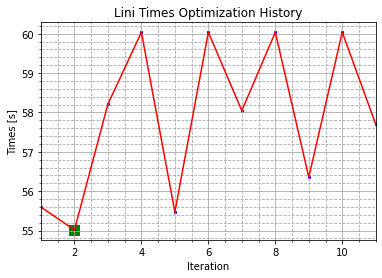

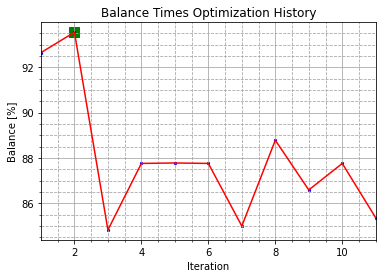

In [ ]:
# Input
# Station and Robot Coordinates
nStation = 3                                # Number of stations
nRobot = np.array([1, 2, 1])                # Number of robots in each station
vRobot = 100                                # Robot velocity [m/s]
coorRobot = np.array([[750, 460.5, 600],    # Starting coordinate at robot 1 - station 1
                     [750, 460.5, 600],     # Starting coordinate at robot 2 - station 1
                     [750, 1381.5, 600],    # Starting coordinate at robot 1 - station 2
                     [750, 1381.5, 600]])   # Starting coordinate at robot 2 - station 3

# GA Parameters
popSize = 50                # Number of population per generation
eliteSize = 2               # Number of elitist
mutationRate = 0.275        # Rate of mutation
crossoverRate = 0.295       # Rate of crossover
generations = 100           # Max. number of generations

# Execute
# This part will execute mini-cases optimization
mainProgram = Execute(nStation, nRobot, coorRobot, vRobot)
mainProgram.optimize(generations, popSize, eliteSize, mutationRate, crossoverRate)

# Post processing
mainProgram.plotLiniTime()
mainProgram.plotBalanceTime()